In [10]:
import numpy as np

landmarks = np.load("/fsx/rs2517/data/HDTF/video_crop/WDA_BarackObama_001.npy")
landmarks.shape

(5625, 68, 2)

In [5]:
from torchvision.io import read_video

video, _, _ = read_video("/fsx/rs2517/data/HDTF/video_crop/WDA_BarackObama_001.mp4", end_pts=10000)
video.shape

torch.Size([20, 1024, 1024, 3])

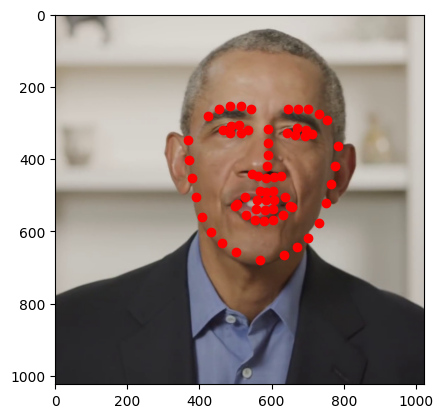

In [14]:
# Plot the first landmark on top of the first frame
import matplotlib.pyplot as plt

idx = 9
plt.imshow(video[idx])
plt.scatter(landmarks[idx, :, 0], landmarks[idx, :, 1], c="red")
plt.show()

In [24]:
import numpy as np
import cv2


def create_masks_from_landmarks_box(landmark_list, img_shape, nose_index=33, dtype="uint8", box_expand=0.0):
    height, width = img_shape[:2]
    num_frames = landmark_list.shape[0]

    # Initialize the masks array
    masks = np.zeros((num_frames, height, width), dtype=dtype)

    if 0 <= box_expand < 1:
        box_expand = int(box_expand * width)

    for i in range(num_frames):
        # Get the landmarks for the current frame
        landmarks = landmark_list[i]

        # Get the y-coordinate of the nose landmark
        nose_point_h = landmarks[nose_index, 1]
        cut_h = nose_point_h

        # Find the leftmost and rightmost landmarks
        far_left_index = np.argmin(landmarks[:, 0])
        far_right_index = np.argmax(landmarks[:, 0])

        # Define the points for the mask contour
        left_up_point = np.array([landmarks[far_left_index][0] - box_expand, cut_h], dtype=np.int32)
        left_down_point = np.array([landmarks[far_left_index][0] - box_expand, height], dtype=np.int32)
        right_up_point = np.array([landmarks[far_right_index][0] + box_expand, cut_h], dtype=np.int32)
        right_down_point = np.array([landmarks[far_right_index][0] + box_expand, height], dtype=np.int32)

        # Define the contour
        contour = np.array([[left_up_point, left_down_point, right_down_point, right_up_point]])

        # Draw the contour on the mask
        cv2.drawContours(masks[i], [contour], -1, color=(1), thickness=cv2.FILLED)

    return torch.from_numpy(masks)


# Example usage:
# landmarks_batch = np.random.randint(100, 300, (10, 68, 2))  # Example with 10 batches of 68 landmarks
# image_height = 400  # Define the height of the image
# image_width = 300  # Define the width of the image
print(landmarks.shape)
masks = create_masks_from_landmarks_box(landmarks[:10], (1024, 1024), box_expand=0)
print(masks.shape)  # This will show (10, 400, 300) confirming the mask sizes

# Interpolating the masks to target size
import torchvision
import torch

masks = (
    torch.nn.functional.interpolate(
        masks.squeeze().unsqueeze(1).float(), size=(512, 512), mode="nearest"
    )
    .squeeze(1)
    .numpy()
)
masks.shape

(5625, 68, 2)
torch.Size([10, 1024, 1024])


(10, 512, 512)

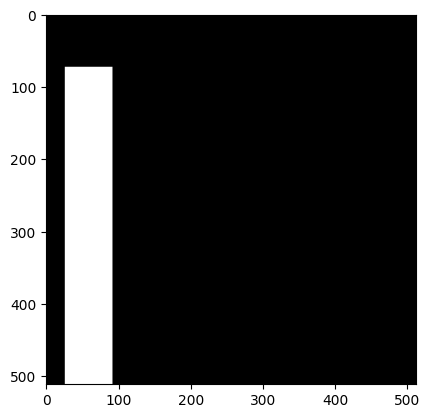

In [26]:
# To visualize one of the masks
import matplotlib.pyplot as plt

plt.imshow(masks[9], cmap="gray")
plt.show()

(6375, 772, 772)


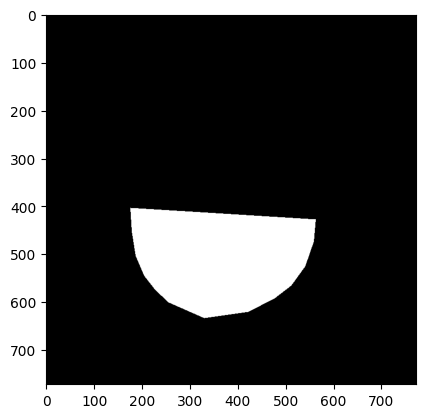

In [34]:
import numpy as np
from PIL import Image, ImageDraw


def expand_polygon(polygon, expand_size):
    """
    Expands the polygon outward by a specified number of pixels.

    Parameters:
    - polygon (list of tuples): The polygon points as (x, y).
    - expand_size (int): The number of pixels to expand the polygon outward.

    Returns:
    - expanded_polygon (list of tuples): The expanded polygon points as (x, y).
    """
    if expand_size == 0:
        return polygon

    # Calculate centroid of the polygon
    centroid_x = sum([point[0] for point in polygon]) / len(polygon)
    centroid_y = sum([point[1] for point in polygon]) / len(polygon)

    # Expand each point outward from the centroid
    expanded_polygon = []
    for x, y in polygon:
        vector_x = x - centroid_x
        vector_y = y - centroid_y
        length = np.sqrt(vector_x**2 + vector_y**2)
        if length == 0:
            expanded_polygon.append((x, y))
        else:
            new_x = x + expand_size * (vector_x / length)
            new_y = y + expand_size * (vector_y / length)
            expanded_polygon.append((int(new_x), int(new_y)))

    return expanded_polygon


def create_face_mask_from_landmarks(landmarks_batch, image_height, image_width, mask_expand=0):
    """
    Creates a batch of masks where each mask covers the face region using landmarks.

    Parameters:
    - landmarks_batch (np.array): An array of shape (B, 68, 2) containing facial landmarks for multiple samples.
    - image_height (int): The height of the image for which masks are created.
    - image_width (int): The width of the image for which masks are created.
    - mask_expand (int): The number of pixels to expand the mask outward.

    Returns:
    - np.array: An array of masks of shape (B, image_height, image_width) for each batch.
    """
    # Initialize an array to hold all masks
    masks = np.zeros((landmarks_batch.shape[0], image_height, image_width), dtype=np.uint8)

    if abs(mask_expand) < 1 and abs(mask_expand) > 0:
        mask_expand = int(mask_expand * image_height)

    for i, landmarks in enumerate(landmarks_batch):
        # Create a blank image for each mask
        mask = Image.new("L", (image_width, image_height), 0)
        draw = ImageDraw.Draw(mask)

        # Extract relevant landmarks for the face
        jawline_landmarks = landmarks[2:15]  # Jawline
        # upper_face_landmarks = landmarks[17:27]  # Eyebrows and top of nose bridge

        # Combine landmarks to form a polygon around the face
        # face_polygon = np.concatenate((jawline_landmarks, upper_face_landmarks[::-1]), axis=0)
        face_polygon = jawline_landmarks

        # Convert landmarks to a list of tuples
        face_polygon = [(int(x), int(y)) for x, y in face_polygon]

        # Expand the polygon if necessary
        expanded_polygon = expand_polygon(face_polygon, mask_expand)

        # Draw the polygon and fill it
        draw.polygon(expanded_polygon, outline=1, fill=1)

        # Convert mask to numpy array and add it to the batch of masks
        masks[i] = np.array(mask)

    return masks


# Example usage:
landmarks_batch = np.random.randint(100, 300, (10, 68, 2))  # Example with 10 batches of 68 landmarks
image_height = 772  # Define the height of the image
image_width = 772  # Define the width of the image
masks = create_face_mask_from_landmarks(landmarks, image_height, image_width, mask_expand=0.1)
print(masks.shape)  # This will show (10, 400, 300) confirming the mask sizes
# masks = (
#     torch.nn.functional.interpolate(torch.tensor(masks).unsqueeze(1).float(), size=(512, 512), mode="nearest")
#     .squeeze(1)
#     .numpy()
# )
# To visualize one of the masks
import matplotlib.pyplot as plt

plt.imshow(masks[0], cmap="gray")
plt.show()

In [1]:
from torchvision.io import read_video

video, audio, info = read_video("/fsx/rs2517/data/HDTF/video_crop/WDA_BarackObama_001.mp4", end_pts=0.1)
from PIL import Image

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [2]:
print(video.shape)

torch.Size([1, 1024, 1024, 3])


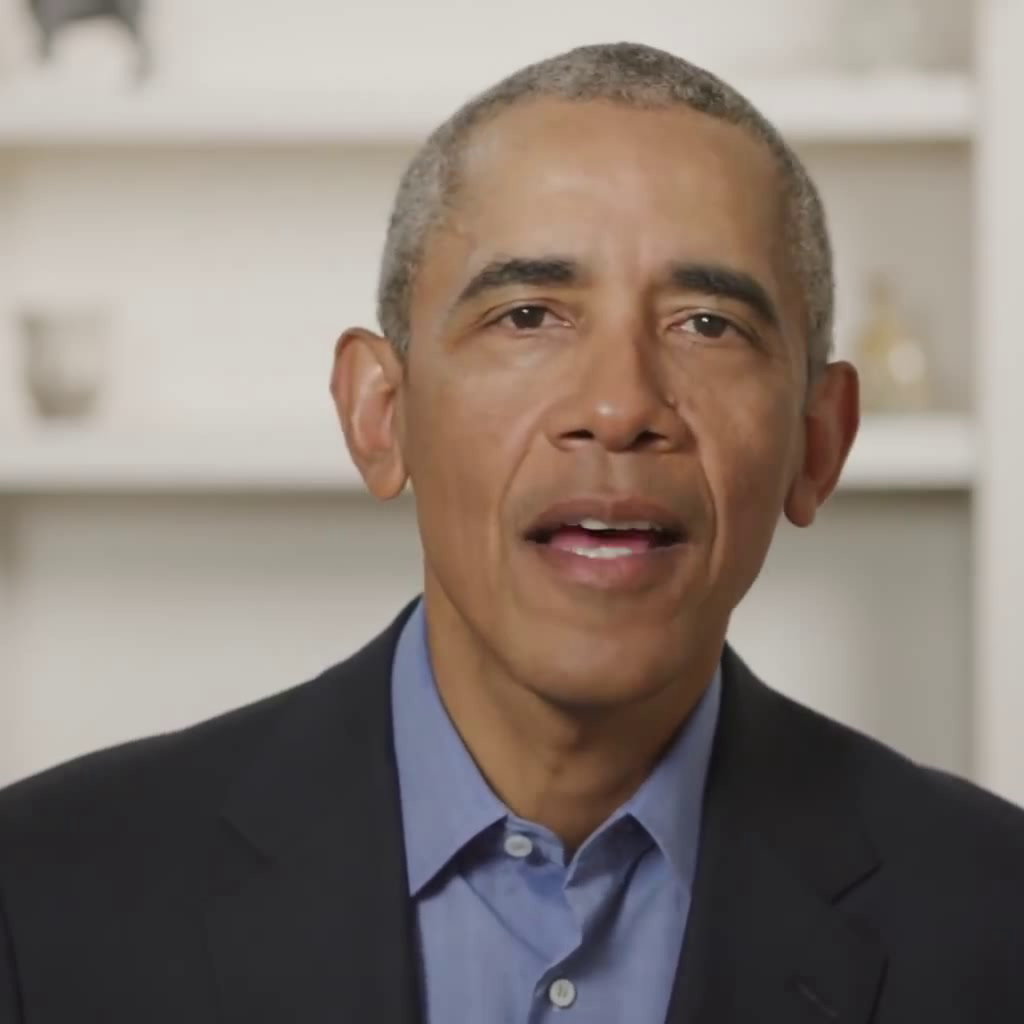

In [8]:
Image.fromarray(video[0].numpy())

In [29]:
import cv2
import numpy as np
import math


def draw_kps_image(image_shape, landmarks, color_list=[(255, 0, 0), (0, 255, 0), (0, 0, 255)], rgb=True, pts_width=4):
    stick_width = pts_width
    limb_seq = np.array([[0, 2], [1, 2]])
    kps = landmarks[[36, 45, 33], :]
    if not rgb:  # Grayscale image
        canvas = np.zeros((image_shape[0], image_shape[1], 1))
        color_mode = "grayscale"
    else:  # Color image
        canvas = np.zeros((image_shape[0], image_shape[1], 3))
        color_mode = "color"

    polygon_cache = {}

    for index in limb_seq:
        color = color_list[index[0]]
        if color_mode == "grayscale":
            color = (int(0.299 * color[2] + 0.587 * color[1] + 0.114 * color[0]),)  # Convert to grayscale intensity

        x = kps[index][:, 0]
        y = kps[index][:, 1]
        length = np.sqrt((x[0] - x[1]) ** 2 + (y[0] - y[1]) ** 2)
        angle = math.degrees(math.atan2(y[0] - y[1], x[0] - x[1]))

        cache_key = (color, int(np.mean(x)), int(np.mean(y)), int(length / 2), int(angle))
        if cache_key not in polygon_cache:
            polygon_cache[cache_key] = cv2.ellipse2Poly(
                (int(np.mean(x)), int(np.mean(y))), (int(length / 2), stick_width), int(angle), 0, 360, 1
            )

        polygon = polygon_cache[cache_key]
        cv2.fillConvexPoly(canvas, polygon, [int(c * 0.6) for c in color])

    for idx, kp in enumerate(kps):
        if color_mode == "grayscale":
            color = (int(0.299 * color_list[idx][2] + 0.587 * color_list[idx][1] + 0.114 * color_list[idx][0]),)
        else:
            color = color_list[idx]
        cv2.circle(canvas, (int(kp[0]), int(kp[1])), pts_width, color, -1)

    return canvas


idx = 1
canvas = draw_kps_image(video[idx].shape[:2], landmarks[idx], rgb=False)
from PIL import Image

print(canvas.shape, canvas.max(), canvas.min())
display(Image.fromarray(canvas.squeeze().astype(np.uint8), mode="L"))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [13]:
cv2.__version__

'4.6.0'

3.5500621795654297


IndexError: index 2000 is out of bounds for dimension 0 with size 1

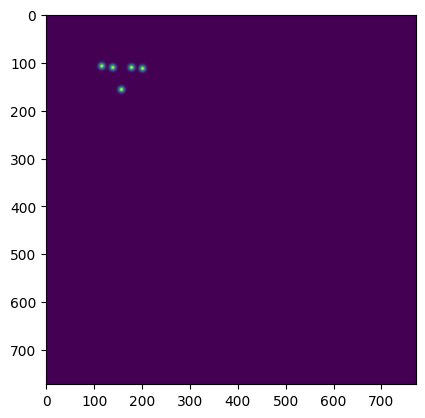

In [27]:
ALL_FIXED_POINTS = (
    [i for i in range(0, 4)] + [i for i in range(13, 17)] + [i for i in range(27, 36)] + [36, 39, 42, 45]
)
from functools import partial
import torch


# def gaussian_k(x0, y0, sigma, width, height):
#     """Make a square gaussian kernel centered at (x0, y0) with sigma as SD."""
#     x = torch.arange(0, width, 1)
#     y = torch.arange(0, height, 1).unsqueeze(1)
#     constant = -1 / (2 * sigma**2)
#     return torch.exp(constant * ((x - x0) ** 2 + (y - y0) ** 2))


# # https://www.researchgate.net/figure/Example-face-image-annotated-with-68-landmarks_fig1_37434867
# def generate_hm(landmarks, height, width, n_points="all", sigma=3):
#     if n_points == "all":
#         Nlandmarks = range(len(landmarks))
#     elif n_points == "fixed":
#         Nlandmarks = ALL_FIXED_POINTS
#     elif n_points == "stable":
#         Nlandmarks = [33, 36, 39, 42, 45]
#     hm = torch.zeros((height, width))
#     for i in Nlandmarks:
#         hm += gaussian_k(landmarks[i][0], landmarks[i][1], sigma, width, height)

#     return hm

import torch


def gaussian_kernel(sigma, width, height):
    """Create a 2D Gaussian kernel."""
    x = torch.arange(0, width, 1) - width // 2
    y = torch.arange(0, height, 1) - height // 2
    x = x.float()
    y = y.float()
    x2 = x**2
    y2 = y[:, None] ** 2
    g = torch.exp(-(x2 + y2) / (2 * sigma**2))
    return g / g.sum()


def generate_hm(landmarks, height, width, n_points="all", sigma=3):
    if n_points == "all":
        Nlandmarks = range(len(landmarks))
    elif n_points == "fixed":
        Nlandmarks = ALL_FIXED_POINTS
    elif n_points == "stable":
        Nlandmarks = [33, 36, 39, 42, 45]

    kernel = gaussian_kernel(sigma, width, height)
    hm = torch.zeros((height, width))
    for I in Nlandmarks:
        x0, y0 = landmarks[I]
        x0, y0 = int(x0), int(y0)
        left, right = max(0, x0 - width // 2), min(width, x0 + width // 2)
        top, bottom = max(0, y0 - height // 2), min(height, y0 + height // 2)
        hm[top:bottom, left:right] += kernel[
            max(0, -y0 + height // 2) : min(height, height - y0 + height // 2),
            max(0, -x0 + width // 2) : min(width, width - x0 + width // 2),
        ]

    # Normalize the heatmap to have values between 0 and 1
    max_val = hm.max()
    if max_val > 0:
        hm /= max_val
    return hm


def get_heatmap(landmarks, image_size, n_points="all", sigma=4):
    stack = []
    seq_length = landmarks.shape[0]
    gen_single_heatmap = partial(
        generate_hm,
        height=image_size[0],
        width=image_size[1],
        n_points=n_points,
        sigma=sigma,
    )
    for i in range(seq_length):
        stack.append(gen_single_heatmap(landmarks[i]))

    return torch.stack(stack, axis=0).unsqueeze(0)


frame = 2000
import time

start = time.time()
heatmap = get_heatmap(landmarks[frame : frame + 100], (772, 772), n_points="stable", sigma=4)
print(time.time() - start)
heatmap.shape

# display first frame on top of original image
import matplotlib.pyplot as plt

plt.imshow(heatmap[0, 0].numpy())
plt.imshow(video[frame], alpha=0.5)
plt.show()

In [4]:
heatmap.max(), heatmap.min()

(tensor(1.), tensor(0.))

In [5]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=0)


landmarks_image = create_landmarks_image(landmarks[0], target_size=(224, 224), point_size=2)

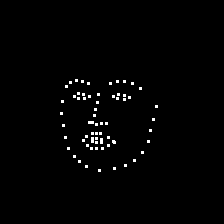

In [6]:
from PIL import Image

landmarks_image_rescaled = (landmarks_image.transpose(1, 2, 0) / 255.0) * 2 - 1
landmarks_image_rescaled = np.clip(landmarks_image_rescaled, -1, 1)
landmarks_image_rescaled = ((landmarks_image_rescaled + 1) / 2 * 255).astype(np.uint8)

# Display the the landmarks with number on landmarks
img = Image.fromarray(landmarks_image_rescaled)

In [7]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    scaled_landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(scaled_landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=-1)


def overlay_landmarks_on_tensor(original_tensor, landmarks, point_size=3):
    """
    Overlay landmarks on an existing image tensor.

    Parameters:
    - original_tensor (np.array): Original image tensor of shape (772, 772, 3).
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - point_size (int): Diameter of each landmark point.

    Returns:
    - overlaid_image (np.array): Image tensor with landmarks overlaid.
    """
    landmarks_image = create_landmarks_image(
        landmarks, target_size=(original_tensor.shape[1], original_tensor.shape[0]), point_size=point_size
    )
    landmarks_array = np.array(landmarks_image)

    # Overlay the landmarks on the original image
    overlaid_image = np.maximum(original_tensor, landmarks_array)
    return overlaid_image


offset = 0
for i in range(10):
    overlayed = overlay_landmarks_on_tensor(video[offset + i].numpy(), landmarks[offset + i], point_size=4) * (
        1 - masks[offset + i, :, :, None]
    ).astype(np.uint8)
    print(overlayed.shape, overlayed.dtype)
    display(Image.fromarray(overlayed))

TypeError: create_landmarks_image() got an unexpected keyword argument 'image_size'

(0.05580880888737738, 0.00594943598844111)